# About The Project

This project was created to fulfilling final task namely 'Karya Ilmiah' in my campus. The objective is simply just to pick the best ARIMA model between possible combination of ARIMA(p,d,q) in forecasting 'Nilai Tukar Nelayan' (NTN) for the next 6 months. The best model will be choosen based on its MAPE, the smaller its MAPE the better it is.

# Dataset Used

The dataset was downloaded from official website of 'Badan Pusat Statistik' (BPS), it contains 61 rows of 'Nilai Tukar Nelayan' in Jawa Timur under the period of January 2018 - January 2023. You can access it via [this link](https://jatim.bps.go.id/indicator/154/523/1/nilai-tukar-nelayan-provinsi-jawa-timur-2018-100-.html)

In [1]:
#import library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from scipy import stats
from sklearn.utils.extmath import squared_norm

from itertools import combinations
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA

In [3]:
#load data set

df = pd.read_excel('dataset/monthly_nilai_tukar_nelayan_2018_2023_jan.xlsx')
df.head()

,bulan,nilai_tukar_nelayan
0,2018/01,99.21
1,2018/02,100.15
2,2018/03,98.78
3,2018/04,99.41
4,2018/05,100.31


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bulan                61 non-null     object 
 1   nilai_tukar_nelayan  61 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.1+ KB


In [5]:
#statistics summary

df.describe()

,nilai_tukar_nelayan
count,61.000000
mean,99.826885
std,3.099984
min,93.900000
25%,97.690000
50%,99.570000
75%,102.450000
max,105.100000


# **Exploratory Data Analysis**

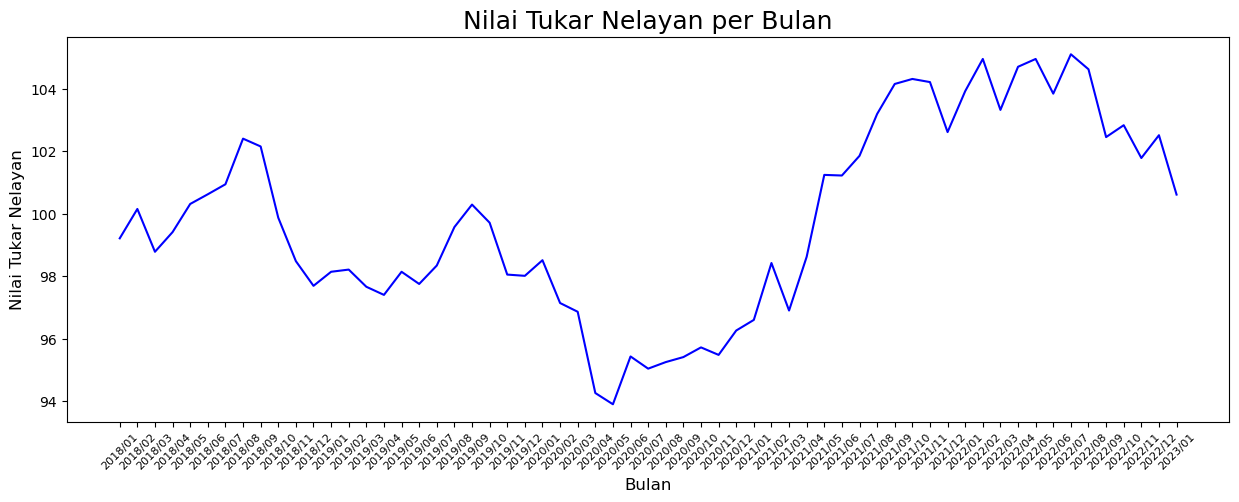

In [6]:
# line plot of 'nilai tukar nelayan'

plt.figure(figsize=(15,5))
plt.plot(df.bulan, df.nilai_tukar_nelayan, color='blue')
plt.title('Nilai Tukar Nelayan per Bulan', fontsize=18)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Nilai Tukar Nelayan', fontsize=12)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=10)
plt.show()

# **Stationary Check**

### Stationary In mean

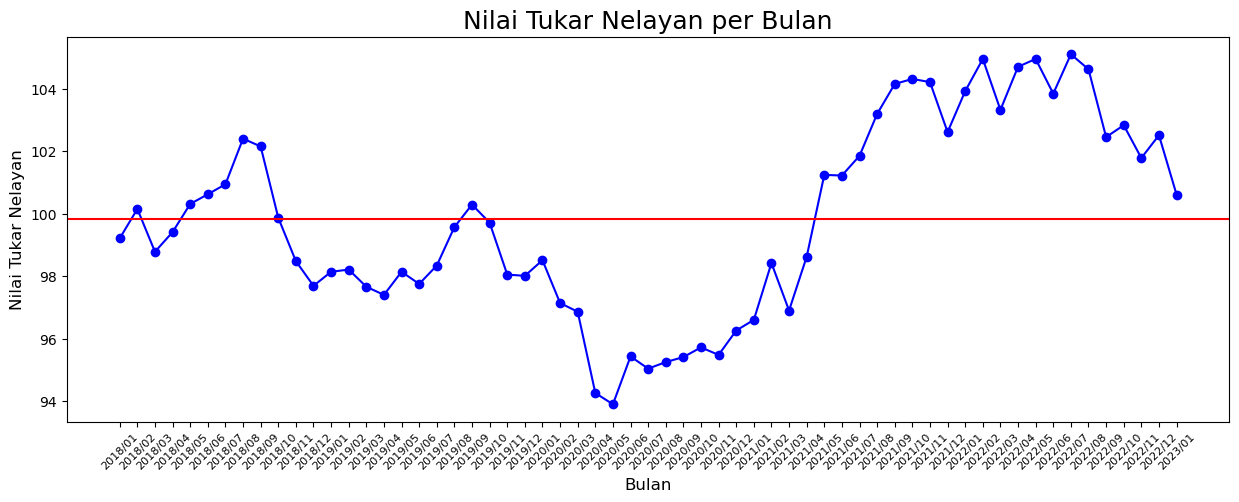

In [7]:
#line plot of 'nilai tukar nelayan'

plt.figure(figsize=(15,5))
plt.plot(df.bulan, df.nilai_tukar_nelayan, color='blue', marker='o')
plt.title('Nilai Tukar Nelayan per Bulan', fontsize=18)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Nilai Tukar Nelayan', fontsize=12)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=10)
plt.axhline(y=np.nanmean(df.nilai_tukar_nelayan), color='red')
plt.show()

In [17]:
#using ad-fuller test
#H0: data isn't stationary
#H1: data is stationary

def adfuller_test(nilai):
  result = adfuller(nilai)
  labels = ['ADF test statistic', 'p-value', 'Lags used', 'Number of observations used']
  for value, label in zip(result, labels):
    print(label+' : ' + str(value) )
  if result[1] <= 0.05:
    print('reject null hyphothesis, data is stationary')
  else:
    print('failed to reject null hyphothesis, data is not stationary')

In [9]:
adfuller_test(df['nilai_tukar_nelayan'])

ADF test statistic : -1.3931622531836494
p-value : 0.5855497947168844
Lags used : 0
Number of observations used : 60
failed to reject null hyphothesis, data is not stationary


* from above line plot, we can clearly see that the data points isn't spread evenly in above the average line and below the average line. this indicates, the dataset isn't stationary.

* from above histogram, we can take conclusion that the data isn't normally distributed because it doesn't form a perfect bell curved. Thus, the data isn't stationary in variance.

* next, we conduct ad-fuller test. the result is, we accept null hypothesis thus our dataset isn't stationer in mean.

### Stationary In variance

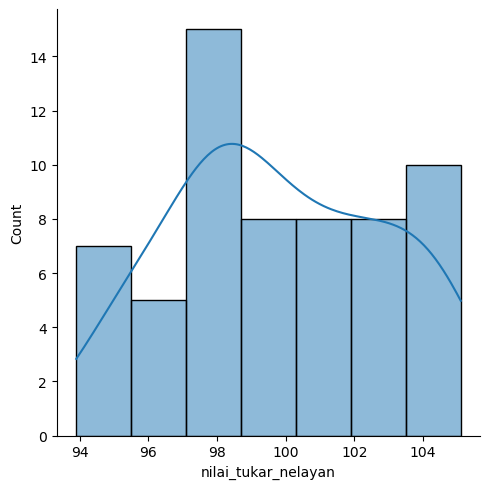

In [10]:
#histogram and univariate distribution of the data

sns.displot(df['nilai_tukar_nelayan'], kde=True)

In [4]:
#calculate the mean and variance of the transformed data

def quick_mean_var(X):
  split = round(len(X) / 2)
  X1, X2 = X[0:split], X[split:]
  mean1, mean2 = np.round(X1.mean(),2), np.round(X2.mean(),2)
  var1, var2 = np.round(X1.var(),2), np.round(X2.var(),2)
  print('mean1 is {}, mean2 is {}'.format(mean1, mean2))
  print('var1 is {}, var2 is {}'.format(var1, var2))

In [5]:
quick_mean_var(df.nilai_tukar_nelayan)

mean1 is 98.58, mean2 is 101.03
var1 is 3.83, var2 is 12.46


# **Making the Data Stationary in Mean and Variance**

## Tackling non-stationary in variance

In [6]:
#overcome non-stationary in variance
#conduct (log / square root / cube root) transformation
#np.log, np.sqrt, np.cbrt

df_copy = df.copy()
log_t = np.log(df_copy['nilai_tukar_nelayan'])
sqrt_t = np.sqrt(df_copy['nilai_tukar_nelayan'])
cbrt_t = np.cbrt(df_copy['nilai_tukar_nelayan'])


In [7]:
log_t

0     4.597239
1     4.606669
2     4.592895
3     4.599253
4     4.608265
        ...   
56    4.629375
57    4.633077
58    4.622814
59    4.629960
60    4.611252
Name: nilai_tukar_nelayan, Length: 61, dtype: float64

Text(0.5, 1.0, 'cbrt')

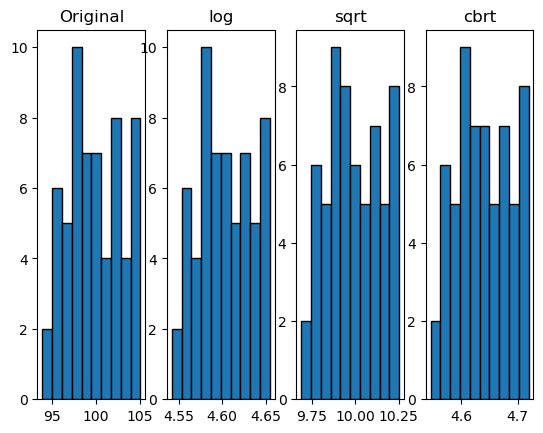

In [8]:
#placing histogram before vs. after transformation in one plot

fig, ax = plt.subplots(nrows=1, ncols=4)

ax[0].hist(df['nilai_tukar_nelayan'], edgecolor='black')
ax[1].hist(log_t, edgecolor='black')
ax[2].hist(sqrt_t, edgecolor='black')
ax[3].hist(cbrt_t, edgecolor='black')

ax[0].set_title('Original')
ax[1].set_title('log')
ax[2].set_title('sqrt')
ax[3].set_title('cbrt')


In [16]:
quick_mean_var(log_t)

mean1 is 4.59, mean2 is 4.61
var1 is 0.0, var2 is 0.0


In [17]:
quick_mean_var(sqrt_t)

mean1 is 9.93, mean2 is 10.05
var1 is 0.01, var2 is 0.03


In [18]:
quick_mean_var(cbrt_t)

mean1 is 4.62, mean2 is 4.66
var1 is 0.0, var2 is 0.0


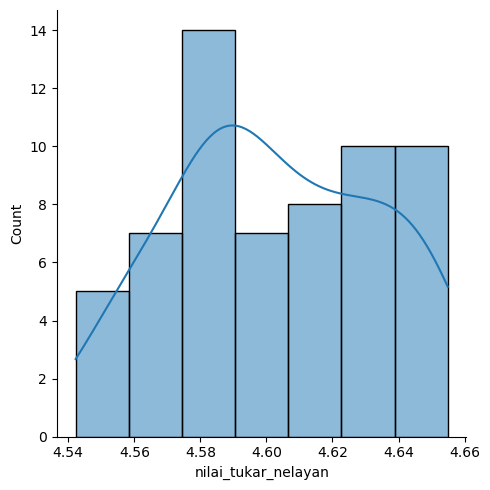

In [19]:
#histogram and univariate distribution plot of the data that has been performed log transformation
#we use log transformation, because the difference between the spilled data isn't quite high

sns.displot(log_t, kde=True)

In [9]:
#put transformed data into original df

df.insert(2, "ntn_log_transformed", log_t.tolist(), True)
df

,bulan,nilai_tukar_nelayan,ntn_log_transformed
0,2018/01,99.21,4.597239
1,2018/02,100.15,4.606669
2,2018/03,98.78,4.592895
3,2018/04,99.41,4.599253
4,2018/05,100.31,4.608265
...,...,...,...
56,2022/09,102.45,4.629375
57,2022/10,102.83,4.633077
58,2022/11,101.78,4.622814
59,2022/12,102.51,4.629960


## Tackling non-stationary in mean

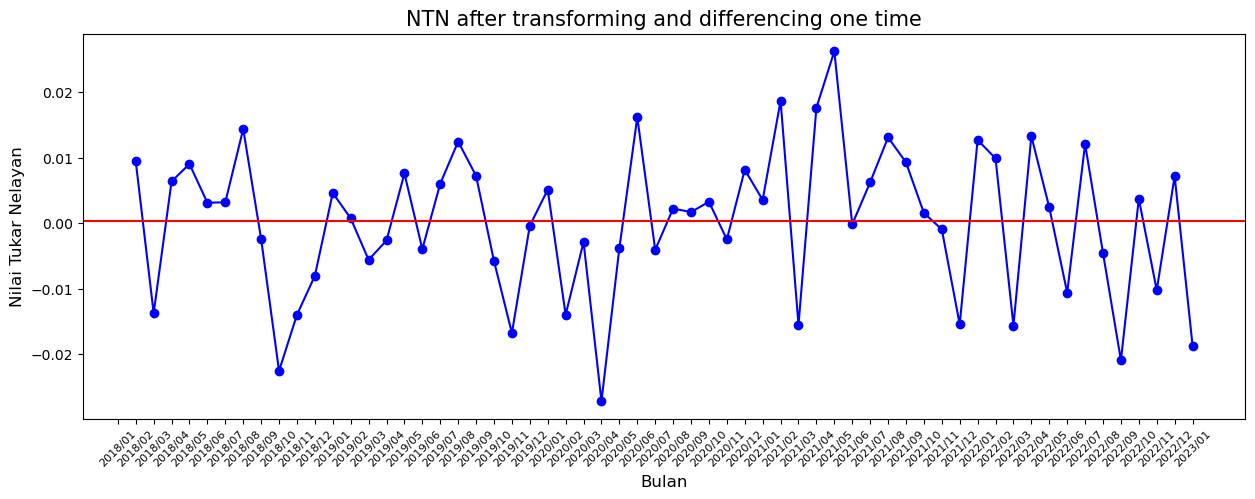

In [11]:
#differencing the data that has been performed log transformation

df['ntn_first_differencing'] = df.ntn_log_transformed - df.ntn_log_transformed.shift(1)

plt.figure(figsize=(15,5))
plt.plot( df.bulan, df['ntn_first_differencing'], color='blue', marker='o')
plt.title('NTN after transforming and differencing one time', fontsize=15)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Nilai Tukar Nelayan', fontsize=12)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=10)
plt.axhline(y=np.nanmean(df.ntn_first_differencing), color='red')
plt.show()

In [12]:
#second differencing

df['ntn_second_differencing'] = df.ntn_first_differencing - df.ntn_first_differencing.shift(1)

In [13]:
df.head()

,bulan,nilai_tukar_nelayan,ntn_log_transformed,ntn_first_differencing,ntn_second_differencing
0,2018/01,99.21,4.597239,NaN,NaN
1,2018/02,100.15,4.606669,0.009430,NaN
2,2018/03,98.78,4.592895,-0.013774,-0.023204
3,2018/04,99.41,4.599253,0.006358,0.020131
4,2018/05,100.31,4.608265,0.009013,0.002655


Yeahh so far so good. Firstly, we must conduct log transformation and then we can do differencing. Let's check again, if it's stationary in variance and mean or not.

# **Second Check before Modeling**

## Log transformation, First Differencing

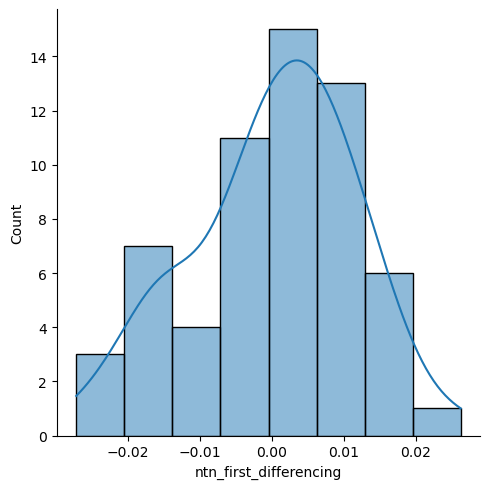

In [15]:
sns.displot(df.ntn_first_differencing.dropna(), kde=True)

In [18]:
adfuller_test(df.ntn_first_differencing.dropna())

ADF test statistic : -7.542099902236929
p-value : 3.3570520472299977e-11
Lags used : 0
Number of observations used : 59
reject null hyphothesis, data is stationary


## Log transformation, Second Differencing

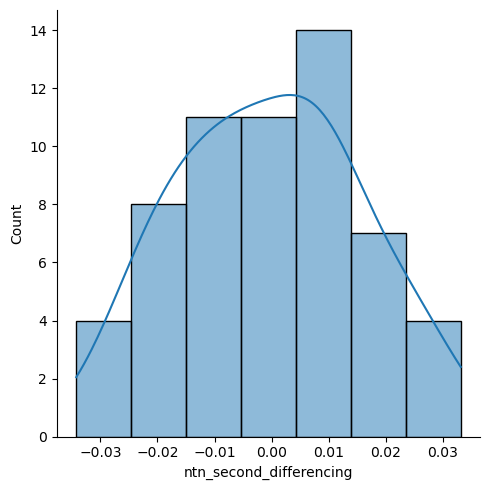

In [19]:
sns.displot(df.ntn_second_differencing.dropna(), kde=True)

In [20]:
adfuller_test(df.ntn_second_differencing.dropna())

ADF test statistic : -6.610263636715486
p-value : 6.403295172615194e-09
Lags used : 3
Number of observations used : 55
reject null hyphothesis, data is stationary


# **ACF and PACF after Conducting Log Transformation and Differencing One Time**

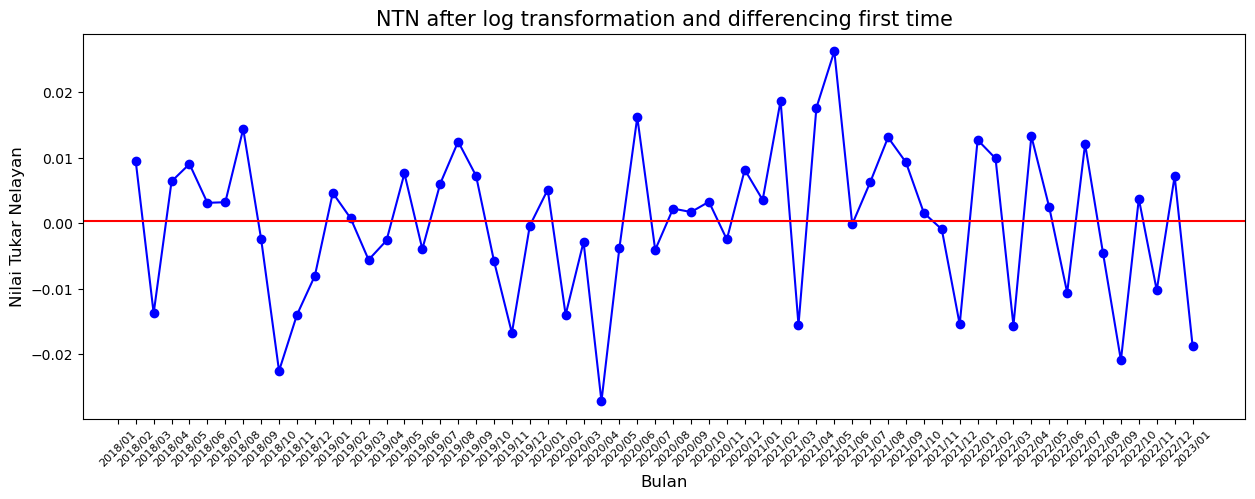

In [21]:
plt.figure(figsize=(15,5))
plt.plot( df.bulan, df['ntn_first_differencing'], color='blue', marker='o')
plt.title('NTN after log transformation and differencing first time', fontsize=15)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Nilai Tukar Nelayan', fontsize=12)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=10)
plt.axhline(y=np.nanmean(df.ntn_first_differencing), color='red')
plt.show()

C:\Users\Roisyah\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


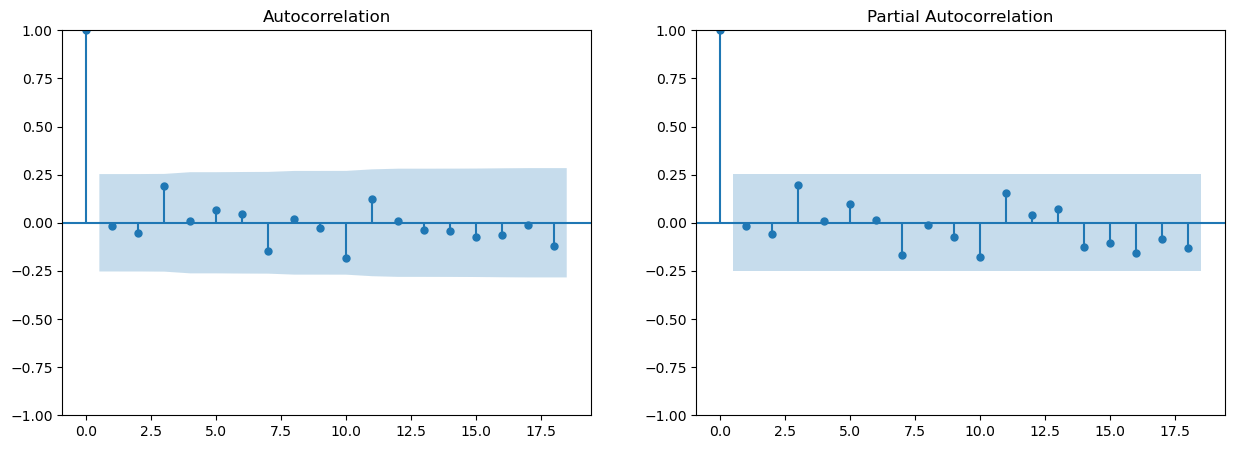

In [22]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
plot_acf(df.ntn_first_differencing.dropna(), ax=ax1)

ax2 = fig.add_subplot(122)
plot_pacf(df.ntn_first_differencing.dropna(), ax=ax2)
plt.show()

for the data that has been performed log transformation and differencing one time we can conclude:
* there's no lag that pass the confident interval
* d=1, thus our model would be (0,1,0)
* the model can't be used, as ARIMA need at least 1 value in p or q

# **ACF and PACF after Conducting Log transformation and Differencing Second Time**

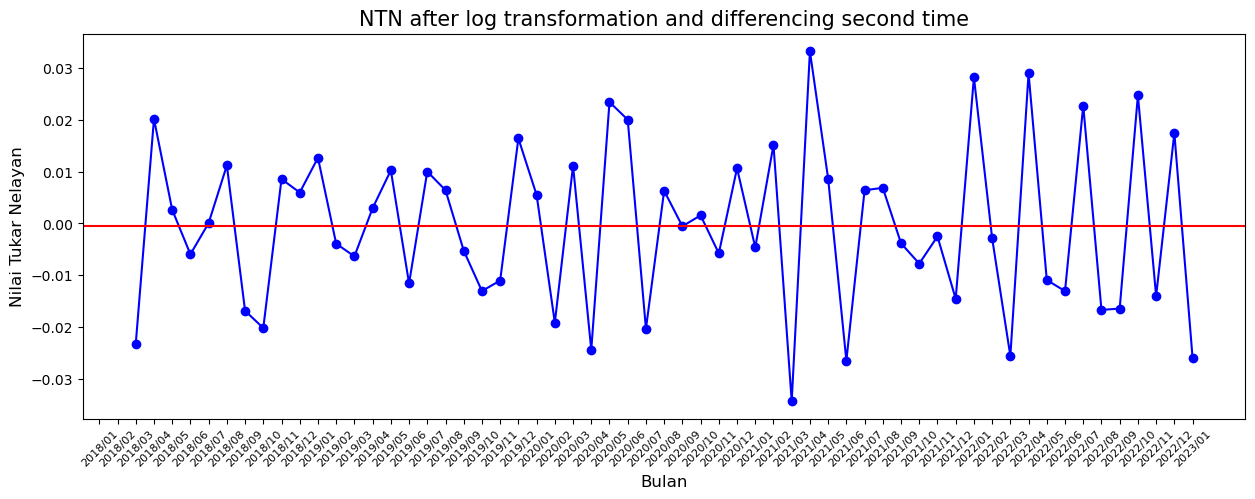

In [23]:
plt.figure(figsize=(15,5))
plt.plot( df.bulan, df['ntn_second_differencing'], color='blue', marker='o')
plt.title('NTN after log transformation and differencing second time', fontsize=15)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Nilai Tukar Nelayan', fontsize=12)
plt.xticks(fontsize=8, rotation=45)
plt.yticks(fontsize=10)
plt.axhline(y=np.nanmean(df.ntn_second_differencing), color='red')
plt.show()

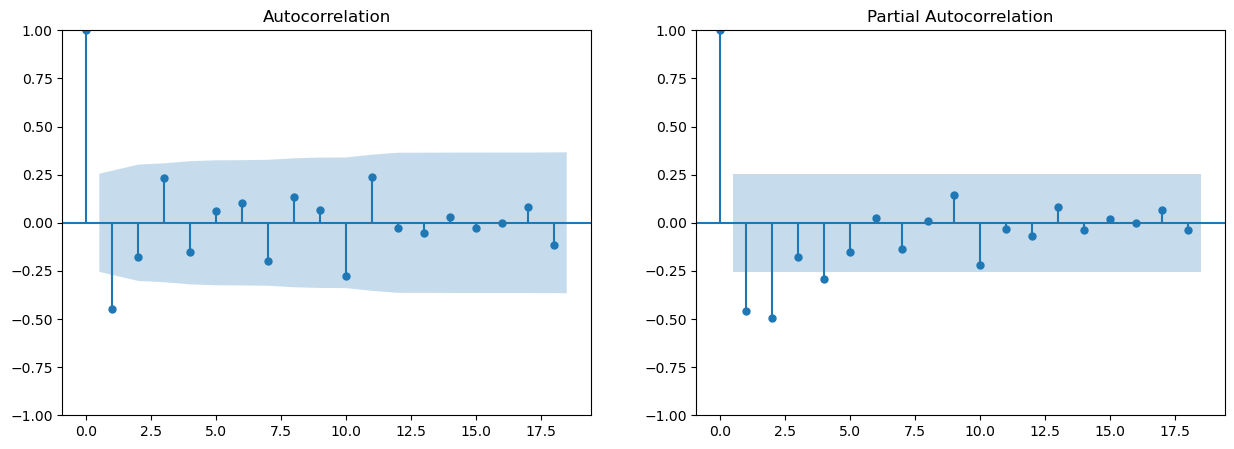

In [24]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(121)
plot_acf(df.ntn_second_differencing.dropna(), ax=ax1)

ax2 = fig.add_subplot(122)
plot_pacf(df.ntn_second_differencing.dropna(), ax=ax2)
plt.show()

for the data that has been performed log transformation and differencing second time we can conclude:
* we have lag 1, 2 and 4 that pass the confident region in PACF
* we have lag 1 that pass the confident region in ACF
* d=2, thus our initial model would be (3,2,1)

# **Searching for Possible ARIMA Model Combination**

In [25]:
#sizing training and test sets in purpose of evaluating model

df_train = df.nilai_tukar_nelayan[:51] #0-51
df_test = df.nilai_tukar_nelayan[51:] #52-61

df_test

51    104.70
52    104.95
53    103.84
54    105.10
55    104.62
56    102.45
57    102.83
58    101.78
59    102.51
60    100.61
Name: nilai_tukar_nelayan, dtype: float64

In [26]:
#what if we take a look of another possible model combination
#model iteration for maximum p is 3, maximum d is 2, and maximum q is 1

from itertools import product

p = range(0,4)
d = range(0,3)
q = range(0,2)

pdq = list(product(p,d,q))

print(pdq)

[(0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 1, 1), (0, 2, 0), (0, 2, 1), (1, 0, 0), (1, 0, 1), (1, 1, 0), (1, 1, 1), (1, 2, 0), (1, 2, 1), (2, 0, 0), (2, 0, 1), (2, 1, 0), (2, 1, 1), (2, 2, 0), (2, 2, 1), (3, 0, 0), (3, 0, 1), (3, 1, 0), (3, 1, 1), (3, 2, 0), (3, 2, 1)]


In [31]:
aic_scores = []
for param in pdq:
  model = ARIMA(df.nilai_tukar_nelayan, order=param)
  model_fit_comb = model.fit()
  aic_scores.append({'par': param, 'aic': model_fit_comb.aic})

aic_scores

C:\Users\Roisyah\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Roisyah\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Roisyah\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Roisyah\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Roisyah\anaco

[{'par': (0, 0, 0), 'aic': 314.1326479435747},
 {'par': (0, 0, 1), 'aic': 253.44536002701847},
 {'par': (0, 1, 0), 'aic': 185.74549787414458},
 {'par': (0, 1, 1), 'aic': 187.71317087818665},
 {'par': (0, 2, 0), 'aic': 224.0701365457426},
 {'par': (0, 2, 1), 'aic': 189.74355996566013},
 {'par': (1, 0, 0), 'aic': 191.81733231220176},
 {'par': (1, 0, 1), 'aic': 193.80877061833704},
 {'par': (1, 1, 0), 'aic': 187.7165829438383},
 {'par': (1, 1, 1), 'aic': 189.7058226415893},
 {'par': (1, 2, 0), 'aic': 211.66491725227132},
 {'par': (1, 2, 1), 'aic': 191.74165260173146},
 {'par': (2, 0, 0), 'aic': 193.8093134751494},
 {'par': (2, 0, 1), 'aic': 194.4453766220937},
 {'par': (2, 1, 0), 'aic': 189.51825340270693},
 {'par': (2, 1, 1), 'aic': 189.82201424700708},
 {'par': (2, 2, 0), 'aic': 197.34057074606278},
 {'par': (2, 2, 1), 'aic': 193.21751670820842},
 {'par': (3, 0, 0), 'aic': 195.76896872275358},
 {'par': (3, 0, 1), 'aic': 196.0807243176892},
 {'par': (3, 1, 0), 'aic': 188.90639876518244},

In [32]:
min(aic_scores, key=lambda x: x['aic'])

{'par': (0, 1, 0), 'aic': 185.74549787414458}

* thus the best model is (0,1,0), it looks weird if p=q=0 because we might be dealing with non-invertible or non-stationary model right now.
* perhaps in the next step, we can try another models (even if the AIC score is bigger than 185.745): 

{'par': (0, 2, 1), 'aic': 189.74354960682828},

{'par': (2, 2, 0), 'aic': 197.34057074561014},

{'par': (1, 2, 0), 'aic': 211.66491725206808},

## **ARIMA (0, 2, 1)**

### ARIMA (0,2,1): predict NTN for the next 6 months

In [33]:
#(0,2,1) didn't split the original data
model_1 = ARIMA(df.nilai_tukar_nelayan, order = (0,2,1))
model_fit_1 = model_1.fit()
print(model_fit_1.summary())

                                SARIMAX Results                                
Dep. Variable:     nilai_tukar_nelayan   No. Observations:                   61
Model:                  ARIMA(0, 2, 1)   Log Likelihood                 -92.872
Date:                 Mon, 14 Aug 2023   AIC                            189.744
Time:                         21:10:14   BIC                            193.899
Sample:                              0   HQIC                           191.366
                                  - 61                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9998      7.165     -0.140      0.889     -15.042      13.043
sigma2         1.2727      9.114      0.140      0.889     -16.591      19.137
Ljung-Box (L1) (Q):                   0.00  

In [34]:
model_fit_1.forecast(6)

61    100.633334
62    100.656669
63    100.680003
64    100.703338
65    100.726672
66    100.750007
Name: predicted_mean, dtype: float64

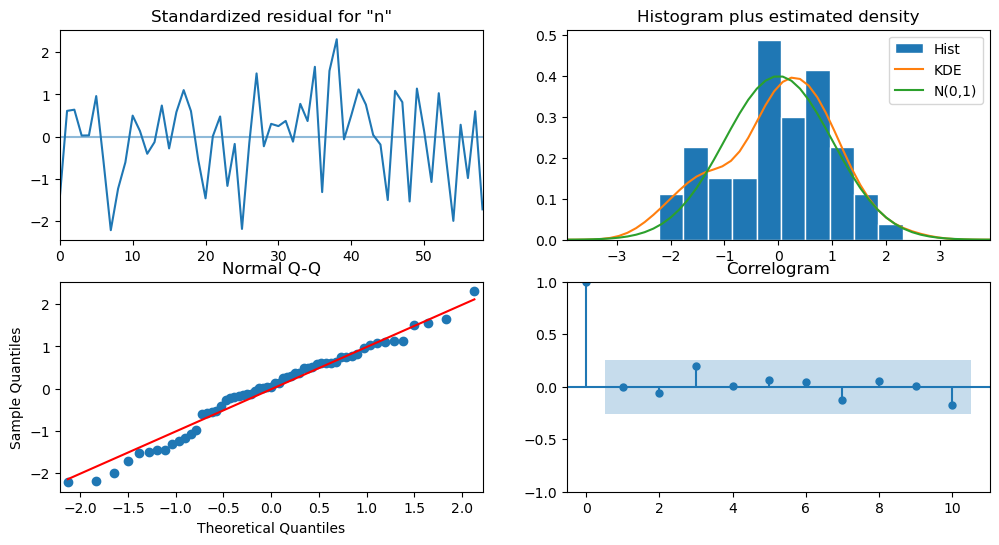

In [35]:
#Diagnostic checking
model_fit_1.plot_diagnostics(figsize=(12,6));

### ARIMA(0,2,1): Using df_train and df_test for model evaluation

In [36]:
#(0,2,1) MODEL EVALUATION
model_1_ev = ARIMA(df_train, order=(0,2,1))
model_fit_1_ev = model_1_ev.fit()
print(model_fit_1_ev.summary())

                                SARIMAX Results                                
Dep. Variable:     nilai_tukar_nelayan   No. Observations:                   51
Model:                  ARIMA(0, 2, 1)   Log Likelihood                 -76.270
Date:                 Mon, 14 Aug 2023   AIC                            156.539
Time:                         21:12:39   BIC                            160.323
Sample:                              0   HQIC                           157.975
                                  - 51                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9592      0.078    -12.340      0.000      -1.111      -0.807
sigma2         1.2510      0.266      4.700      0.000       0.729       1.773
Ljung-Box (L1) (Q):                   0.30  

In [37]:
forecast_test_m1 = model_fit_1_ev.forecast(len(df_test))

df['forecast_m1'] = [None]*len(df_train) + list(forecast_test_m1)

df[['bulan', 'nilai_tukar_nelayan', 'forecast_m1']].tail(10)

,bulan,nilai_tukar_nelayan,forecast_m1
51,2022/04,104.70,103.474367
52,2022/05,104.95,103.628733
53,2022/06,103.84,103.783100
54,2022/07,105.10,103.937467
55,2022/08,104.62,104.091834
56,2022/09,102.45,104.246200
57,2022/10,102.83,104.400567
58,2022/11,101.78,104.554934
59,2022/12,102.51,104.709301
60,2023/01,100.61,104.863667


In [38]:
mae_m1 = mean_absolute_error(df_test, forecast_test_m1)
mape_m1 = mean_absolute_percentage_error(df_test, forecast_test_m1)
rmse_m1 = np.sqrt(mean_squared_error(df_test, forecast_test_m1))
mse_m1 = mean_squared_error(df_test, forecast_test_m1)

print(f'MAE: {mae_m1}')
print(f'MAPE: {mape_m1}')
print(f'MSE: {mse_m1}')
print(f'RMSE: {rmse_m1}')

MAE: 1.688916823297734
MAPE: 0.016475642184704604
MSE: 4.12054856614604
RMSE: 2.0299134380918904


## **ARIMA (2,2,0)**

### ARIMA (2,2,0): predict NTN for the next 6 months

In [39]:
#(2,2,0) didn't split the original data
model_2 = ARIMA(df.nilai_tukar_nelayan, order = (2,2,0))
model_fit_2=model_2.fit()
print(model_fit_2.summary())

                                SARIMAX Results                                
Dep. Variable:     nilai_tukar_nelayan   No. Observations:                   61
Model:                  ARIMA(2, 2, 0)   Log Likelihood                 -95.670
Date:                 Mon, 14 Aug 2023   AIC                            197.341
Time:                         21:14:02   BIC                            203.573
Sample:                              0   HQIC                           199.774
                                  - 61                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6989      0.129     -5.425      0.000      -0.951      -0.446
ar.L2         -0.5057      0.137     -3.704      0.000      -0.773      -0.238
sigma2         1.4785      0.314      4.703 

In [40]:
model_fit_2.forecast(6)

61    99.647859
62    99.360333
63    98.127029
64    97.213539
65    96.554845
66    95.556339
Name: predicted_mean, dtype: float64

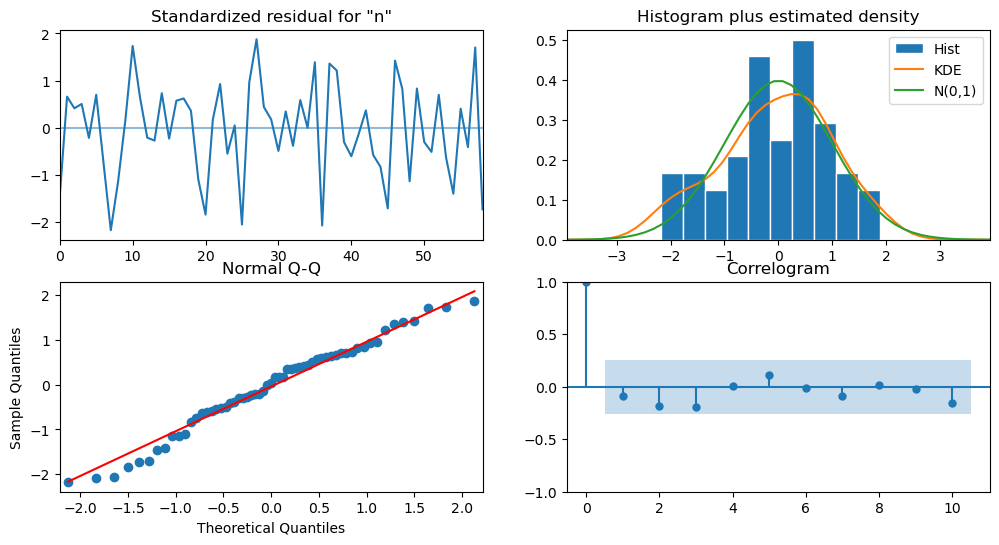

In [41]:
#Diagnostic checking
model_fit_2.plot_diagnostics(figsize=(12,6));

### ARIMA(2,2,0): Using df_train and df_test for model evaluation

In [42]:
#(2,2,0) MODEL EVALUATION
model_2_ev = ARIMA(df_train, order = (2,2,0))
model_fit_2_ev = model_2_ev.fit()
print(model_fit_2_ev.summary())

                                SARIMAX Results                                
Dep. Variable:     nilai_tukar_nelayan   No. Observations:                   51
Model:                  ARIMA(2, 2, 0)   Log Likelihood                 -78.936
Date:                 Mon, 14 Aug 2023   AIC                            163.871
Time:                         21:15:22   BIC                            169.547
Sample:                              0   HQIC                           166.025
                                  - 51                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5692      0.137     -4.167      0.000      -0.837      -0.301
ar.L2         -0.4926      0.160     -3.077      0.002      -0.806      -0.179
sigma2         1.4469      0.321      4.503 

In [43]:
forecast_test_m2 = model_fit_2_ev.forecast(len(df_test))

df['forecast_m2'] = [None]*len(df_train) + list(forecast_test_m2)

df[['bulan', 'nilai_tukar_nelayan', 'forecast_m2']].tail(10)

,bulan,nilai_tukar_nelayan,forecast_m2
51,2022/04,104.70,103.341922
52,2022/05,104.95,103.733931
53,2022/06,103.84,103.101563
54,2022/07,105.10,102.869936
55,2022/08,104.62,102.914826
56,2022/09,102.45,102.604925
57,2022/10,102.83,102.360749
58,2022/11,101.78,102.253934
59,2022/12,102.51,102.036561
60,2023/01,100.61,101.814451


In [44]:
mae_m2 = mean_absolute_error(df_test, forecast_test_m2)
mape_m2 = mean_absolute_percentage_error(df_test, forecast_test_m2)
rmse_m2 = np.sqrt(mean_squared_error(df_test, forecast_test_m2))
mse_m2 = mean_squared_error(df_test, forecast_test_m2)

print(f'MAE: {mae_m2}')
print(f'MAPE: {mape_m2}')
print(f'MSE: {mse_m2}')
print(f'RMSE: {rmse_m2}')

MAE: 1.002382183362542
MAPE: 0.00965087667225359
MSE: 1.3892951379724237
RMSE: 1.178683646264944


## **ARIMA (1,2,0)**

### ARIMA (1,2,0): predict NTN for the next 6 months

In [45]:
#(1,2,0) didn't split the original dataset
model_3 = ARIMA(df.nilai_tukar_nelayan,order=(1,2,0))
model_fit_3=model_3.fit()
print(model_fit_3.summary())

                                SARIMAX Results                                
Dep. Variable:     nilai_tukar_nelayan   No. Observations:                   61
Model:                  ARIMA(1, 2, 0)   Log Likelihood                -103.832
Date:                 Mon, 14 Aug 2023   AIC                            211.665
Time:                         21:16:22   BIC                            215.820
Sample:                              0   HQIC                           213.287
                                  - 61                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4808      0.113     -4.252      0.000      -0.702      -0.259
sigma2         1.9688      0.470      4.185      0.000       1.047       2.891
Ljung-Box (L1) (Q):                   3.05  

In [46]:
model_fit_3.forecast(6)

61    99.974545
62    98.731077
63    97.779952
64    96.688263
65    95.664159
66    94.607560
Name: predicted_mean, dtype: float64

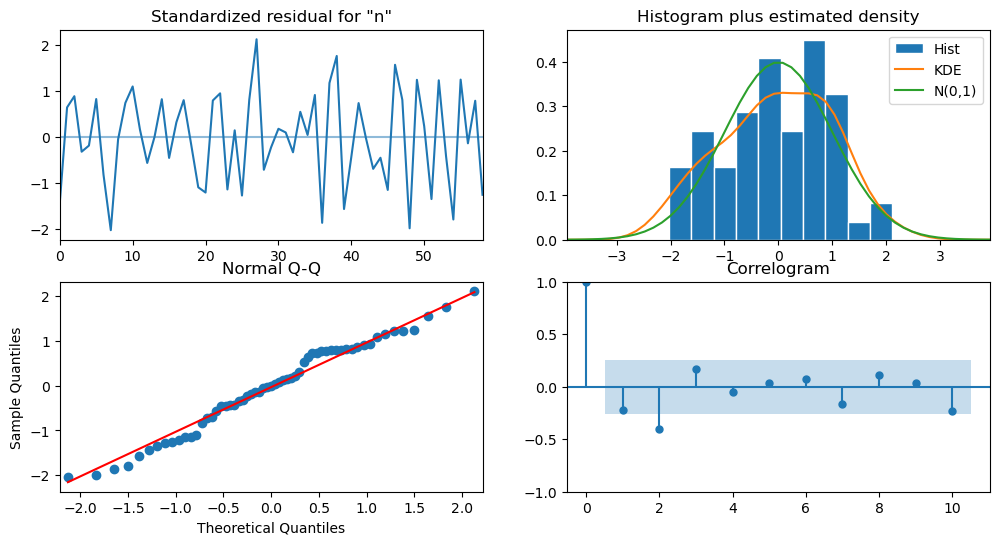

In [47]:
#Diagnostic checking
model_fit_3.plot_diagnostics(figsize=(12,6));

### ARIMA(1,2,0): Using df_train and df_test for model evaluation

In [48]:
#(1,2,0) MODEL EVALUATION
model_3_ev = ARIMA(df_train, order = (1,2,0))
model_fit_3_ev = model_3_ev.fit()
print(model_fit_3_ev.summary())

                                SARIMAX Results                                
Dep. Variable:     nilai_tukar_nelayan   No. Observations:                   51
Model:                  ARIMA(1, 2, 0)   Log Likelihood                 -84.966
Date:                 Mon, 14 Aug 2023   AIC                            173.933
Time:                         21:16:39   BIC                            177.717
Sample:                              0   HQIC                           175.368
                                  - 51                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3889      0.121     -3.216      0.001      -0.626      -0.152
sigma2         1.8716      0.455      4.114      0.000       0.980       2.763
Ljung-Box (L1) (Q):                   1.35  

In [49]:
forecast_test_m3 = model_fit_3_ev.forecast(len(df_test))

df['forecast_m3'] = [None]*len(df_train) + list(forecast_test_m3)

df[['bulan', 'nilai_tukar_nelayan', 'forecast_m3']].tail(10)

,bulan,nilai_tukar_nelayan,forecast_m3
51,2022/04,104.70,102.724402
52,2022/05,104.95,101.726553
53,2022/06,103.84,100.885129
54,2022/07,105.10,99.982876
55,2022/08,104.62,99.104277
56,2022/09,102.45,98.216479
57,2022/10,102.83,97.332259
58,2022/11,101.78,96.446648
59,2022/12,102.51,95.561577
60,2023/01,100.61,94.676297


In [50]:
mae_m3 = mean_absolute_error(df_test, forecast_test_m3)
mape_m3 = mean_absolute_percentage_error(df_test, forecast_test_m3)
rmse_m3 = np.sqrt(mean_squared_error(df_test, forecast_test_m3))
mse_m3 = mean_squared_error(df_test, forecast_test_m3)

print(f'MAE: {mae_m3}')
print(f'MAPE: {mape_m3}')
print(f'MSE: {mse_m3}')
print(f'RMSE: {rmse_m3}')

MAE: 4.673350218982227
MAPE: 0.045339698929086916
MSE: 23.971492752765034
RMSE: 4.896069112335429


## Line plot of predicted vs. actual

In [66]:
def plot_model(train, test, y_pred, title):
    
  mape = mean_absolute_percentage_error(test, y_pred)
  rmse = np.sqrt(mean_squared_error(test, y_pred))
  train.plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAPE: {round(mape, 2)}, RMSE: {round(rmse, 2)}")
  test.plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

In [79]:
y_pred_m2 = df['forecast_m2'][51:61]
title = 'ARIMA(2,2,0) predicted vs actual'

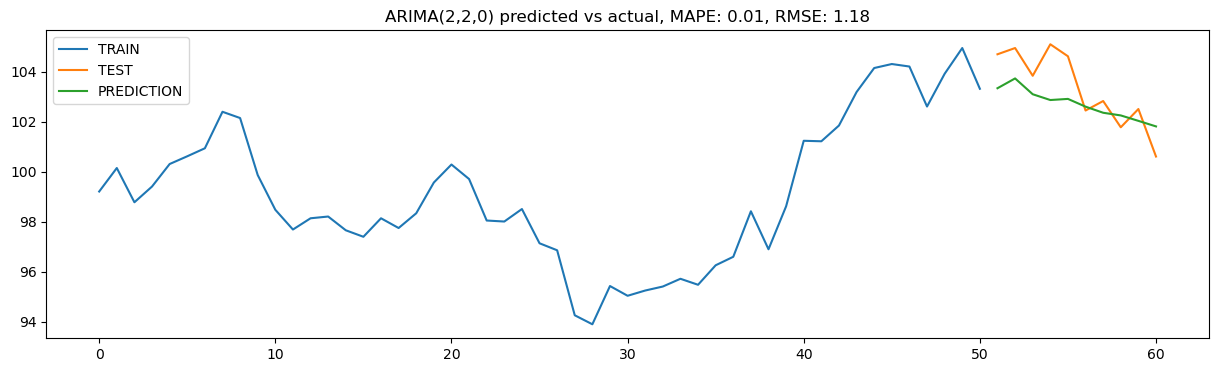

In [80]:
plot_model(df_train, df_test, y_pred_m2, title)

## Conclusion

Here's what we got:

* ARIMA(0,2,1) has MAPE: 0.016475642184704604
* ARIMA(2,2,0) has MAPE: 0.00965087667225359
* ARIMA(1,2,0) has MAPE: 0.045339698929086916

We can conclude that ARIMA(2,2,0) become the best model among these 3 models as it has the smallest MAPE. For the next 6 months (February - July 2023), ARIMA(2,2,0) will predict the NTN with the following value:

* (61)    99.647859
* (62)    99.360333
* (63)    98.127029
* (64)    97.213539
* (65)    96.554845
* (66)    95.556339